<div style="background-color:lightgreen; border-style: dotted;border-color: yellow;text-align:center;color:blue;font-size:20px;border-radius: 50px;padding: 20px 20px;"><strong> Gashaw M. Goshu, PhD in Chemistry</strong></div>

# Calculating molecular descriptors using RDkit and Mordred

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from mordred import Calculator, descriptors

In [2]:
import session_info
session_info.show()

In [3]:
# https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool
# it was an excel file, but converted it to csv file 
dataset = pd.read_csv('D:\Orbital_Energies_input_data.csv')
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


## 1. Generate canonical SMILES

In [4]:
# There might be one or more valid SMILES that can represent one compound
# Thanks to Pat Walters this information: https://www.blogger.com/profile/18223198920629617711
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

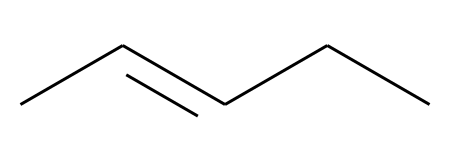

In [5]:
Chem.MolFromSmiles('CC=CCC')

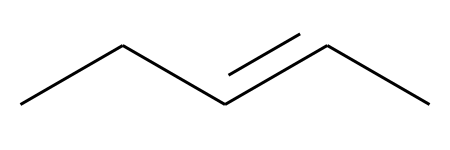

In [6]:
Chem.MolFromSmiles('CCC=CC')

In [7]:
canonical_smiles(['CC=CCC'])

['CC=CCC']

In [8]:
canonical_smiles(['CCC=CC'])

['CC=CCC']

In [9]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(dataset.SMILES)
len(Canon_SMILES)

2904

In [10]:
dataset['SMILES'] = Canon_SMILES
dataset

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


In [11]:
# Create a list for duplicate smiles
duplicates_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

31

In [12]:
# Create a list for duplicate smiles
dataset[dataset['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

,SMILES,Energygap
218,C1=CCCCCCC1,214.097913
2125,C1=CCCCCCC1,214.097913
1901,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
552,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
554,C=CN1CCCC1=O,190.834900
1808,C=CN1CCCC1=O,190.835527
2203,C=Cc1ccccc1,168.467969
1354,C=Cc1ccccc1,168.475499
2341,C=Cc1ccccc1,168.490559
1265,C=Cc1ccncc1,174.833420


## 2.  Drop duplicate values

In [13]:
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
len(dataset_new)

2873

In [14]:
dataset_new

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


## Calculate descriptors using RDkit

### i. General molecular descriptors

In [15]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = np.array(calc.CalcDescriptors(mol))
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(dataset_new['SMILES'])

In [16]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.550510,-5.076351,12.550510,1.008796,0.546828,160.138,153.082,160.049985,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.676844,-3.333333,10.676844,1.840718,0.569323,122.551,115.495,122.013457,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.050084,-4.111425,13.050084,0.722809,0.790287,361.825,341.665,361.108086,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.402685,-0.449630,7.402685,0.074321,0.582519,162.019,156.979,160.979905,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.095237,-4.484184,8.095237,1.886963,0.606746,156.269,136.109,156.151415,66.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.505488,-3.873136,9.505488,0.973292,0.373065,398.426,374.234,398.135324,138.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2869,7.651157,-0.170718,7.651157,0.017477,0.625891,213.099,208.059,211.929533,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2870,13.017078,-3.813937,13.017078,0.325694,0.823664,247.294,230.158,247.120843,96.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2871,7.592407,-0.348333,7.592407,0.030556,0.519376,134.203,128.155,134.019021,44.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### ii. Fingerprints

In [17]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [18]:
Morgan_fpts = morgan_fpts(dataset_new['SMILES'])
Morgan_fpts.shape

(2873, 2048)

In [19]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts,columns=['Col{}'.format(i) for i in range(Morgan_fpts.shape[1])])
Morgan_fingerprints

,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,...,Col2038,Col2039,Col2040,Col2041,Col2042,Col2043,Col2044,Col2045,Col2046,Col2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate descreptors using Mordred

In [20]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

In [21]:
mordred_descriptors = All_Mordred_descriptors(dataset_new['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 2873/2873 [00:30<00:00, 94.67it/s]


In [22]:
mordred_descriptors.shape

(2873, 1826)

In [23]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,8.302711,7.763360,0,0,12.527341,2.311476,4.622953,12.527341,1.138849,3.302522,...,9.182249,41.326257,160.049985,8.891666,152,13,54.0,59.0,5.28472,2.333333
1,4.461420,4.736714,1,0,7.727407,1.931852,3.863703,7.727407,1.103915,2.752227,...,7.321850,31.336140,122.013457,8.715247,52,4,24.0,22.0,3.86111,1.833333
2,19.038123,14.818400,1,0,30.648742,2.324224,4.648448,30.648742,1.225950,4.118873,...,9.931735,59.295845,361.108086,8.024624,1882,35,124.0,139.0,9.72917,5.486111
3,6.651690,6.355891,0,0,10.792280,2.245827,4.491654,10.792280,1.199142,3.099448,...,8.806724,37.839725,160.979905,11.498565,84,10,42.0,46.0,4.08333,2.027778
4,7.399237,7.388977,0,0,12.133645,2.047810,4.095621,12.133645,1.103059,3.219224,...,8.131825,38.565088,156.151415,5.037142,194,9,42.0,41.0,5.47222,2.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,21.758550,17.000581,0,0,38.253985,2.374938,4.749876,38.253985,1.366214,4.258939,...,10.073357,62.971588,398.135324,7.656449,2014,41,142.0,164.0,6.16667,6.361111
2869,7.806684,7.343579,0,0,13.098358,2.369838,4.633950,13.098358,1.309836,3.261311,...,9.161465,53.745115,211.929533,14.128636,105,12,52.0,61.0,2.83333,2.222222
2870,13.382658,11.741399,0,0,22.978744,2.442763,4.885526,22.978744,1.276597,3.800055,...,9.763593,50.871918,247.120843,7.060596,574,28,88.0,103.0,6.05556,4.277778
2871,7.030628,6.547610,0,0,12.170709,2.322596,4.516123,12.170709,1.352301,3.160409,...,8.914761,51.887188,134.019021,8.934601,79,9,46.0,53.0,1.97222,2.027778
